In [28]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [31]:
from zipfile import ZipFile
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# 1. Loading Data and Apply Preprocessing

In [32]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)

In [33]:
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)

In [34]:
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

In [35]:
# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

In [36]:
ratings_file = movielens_dir / "ratings.csv"
tags_file = movielens_dir / "tags.csv"
movies_file = movielens_dir / "movies.csv"

df = pd.read_csv(ratings_file)
tags = pd.read_csv(tags_file)
movies = pd.read_csv(movies_file)

# 2. Exploratory Data Analysis

In [37]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [38]:
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [40]:
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

df["user_idx"] = user_encoder.fit_transform(df["userId"])
df["movie_idx"] = movie_encoder.fit_transform(df["movieId"])

num_users = df["user_idx"].nunique()
num_movies = df["movie_idx"].nunique()

df["rating"] = df["rating"].astype(np.float32)
min_rating, max_rating = df["rating"].min(), df["rating"].max()

print(f"Users: {num_users}, Movies: {num_movies}")
print(f"Rating range: {min_rating} - {max_rating}")

Users: 610, Movies: 9724
Rating range: 0.5 - 5.0


# 3. Preparing the Data

In [41]:
from sklearn.model_selection import train_test_split

X = df[["user_idx", "movie_idx"]].values
y = (df["rating"] - min_rating) / (max_rating - min_rating)

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=42
)

In [42]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_dim=50, **kwargs):
        super().__init__(**kwargs)

        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_dim,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

        self.movie_embedding = layers.Embedding(
            input_dim=num_movies,
            output_dim=embedding_dim,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_idx = inputs[:, 0]
        movie_idx = inputs[:, 1]

        user_vec = self.user_embedding(user_idx)
        movie_vec = self.movie_embedding(movie_idx)

        user_bias = self.user_bias(user_idx)
        movie_bias = self.movie_bias(movie_idx)

        # Dot product between user and movie embeddings
        dot = tf.reduce_sum(user_vec * movie_vec, axis=1, keepdims=True)

        x = dot + user_bias + movie_bias

        # Output normalized rating in [0,1]
        return tf.nn.sigmoid(x)


In [43]:
model = RecommenderNet(num_users, num_movies, embedding_dim=50)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

# 5. Train the Model on the Data Split

EarlyStopping: 
1. prevents overfitting
2. Uses best weights
3. You can safely increase epochs without risk

In [44]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=20,           # allow more epochs, early stopping will control
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0595 - root_mean_squared_error: 0.2432 - val_loss: 0.0434 - val_root_mean_squared_error: 0.2060
Epoch 2/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0369 - root_mean_squared_error: 0.1880 - val_loss: 0.0390 - val_root_mean_squared_error: 0.1924
Epoch 3/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0307 - root_mean_squared_error: 0.1680 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1888
Epoch 4/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0260 - root_mean_squared_error: 0.1507 - val_loss: 0.0391 - val_root_mean_squared_error: 0.1883
Epoch 5/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0223 - root_mean_squared_error: 0.1354 - val_loss: 0.0400 - val_root_mean_squared_error: 0.1890
Epoch 6/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0196 - root_mean_squared_error: 0.1228 - val_loss: 0.0410 - val_root_mean_squared_error: 0.1902


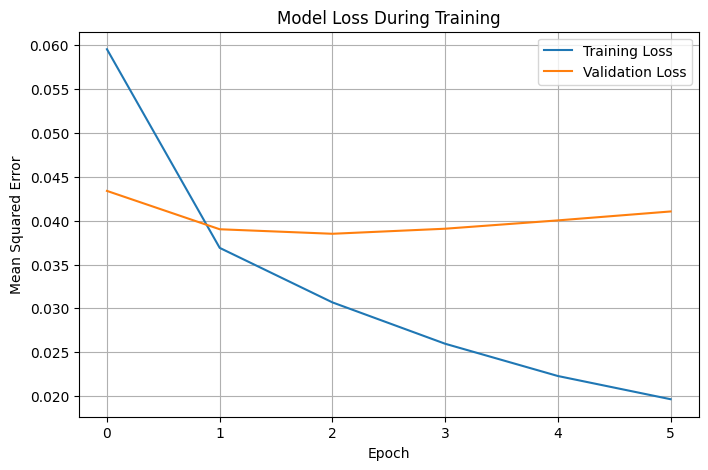

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("Model Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)

plt.show()

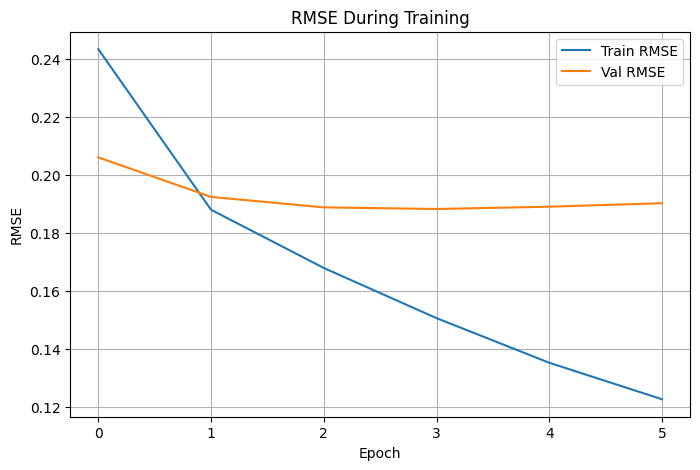

In [46]:
plt.figure(figsize=(8, 5))

plt.plot(history.history["root_mean_squared_error"], label="Train RMSE")
plt.plot(history.history["val_root_mean_squared_error"], label="Val RMSE")

plt.title("RMSE During Training")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)

plt.show()

# 6. Show top 5 High Ratings movies from users

In [47]:
user_id = df["userId"].sample(1).iloc[0]
movie_df = pd.read_csv(movielens_dir / "movies.csv")
movies_watched_by_user = df[df["userId"] == user_id]

print(f"Showing recommendations for user: {user_id}")
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)

top_movies_user = (
    movies_watched_by_user
    .sort_values(by="rating", ascending=False)
    .head(5)["movieId"]
    .values
)

movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]

for row in movie_df_rows.itertuples():
    print(f"{row.title} : {row.genres}")

Showing recommendations for user: 253
Movies with high ratings from user
--------------------------------
Farewell My Concubine (Ba wang bie ji) (1993) : Drama|Romance
Life Is Beautiful (La Vita è bella) (1997) : Comedy|Drama|Romance|War
Election (1999) : Comedy
All About My Mother (Todo sobre mi madre) (1999) : Drama
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) : Comedy|Romance


# 6. Show top 10 movie recommendations to a user

In [48]:
# Movies not watched by user
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user["movieId"])
]["movieId"].values

# Keep only movies seen during training
known_movie_ids = set(movie_encoder.classes_)
movies_not_watched = [
    m for m in movies_not_watched if m in known_movie_ids
]

# Encode user & movies
user_idx = user_encoder.transform([user_id])[0]
movie_indices = movie_encoder.transform(movies_not_watched)

# Prepare model input
user_movie_array = np.column_stack(
    ([user_idx] * len(movie_indices), movie_indices)
)

# Predict
ratings = model.predict(user_movie_array, verbose=0).flatten()

top_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [movies_not_watched[i] for i in top_indices]


In [51]:
print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)

recommended_movies = movie_df[
    movie_df["movieId"].isin(recommended_movie_ids)
]

for row in recommended_movies.itertuples():
    print(f"{row.title} : {row.genres}")

--------------------------------
Top 10 movie recommendations
--------------------------------
Usual Suspects, The (1995) : Crime|Mystery|Thriller
Star Wars: Episode IV - A New Hope (1977) : Action|Adventure|Sci-Fi
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
Shawshank Redemption, The (1994) : Crime|Drama
Schindler's List (1993) : Drama|War
Godfather, The (1972) : Crime|Drama
Casablanca (1942) : Drama|Romance
12 Angry Men (1957) : Drama
Godfather: Part II, The (1974) : Crime|Drama
Fight Club (1999) : Action|Crime|Drama|Thriller


In [ ]:
model.save("../model/recommender_model.keras")

NotImplementedError: 
Object RecommenderNet was created by passing
non-serializable argument values in `__init__()`,
and therefore the object must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:


class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
